Name and Surname: CUONG VO\
Student ID: 131116

Using CUDA for GPU processing (on Linux OS)

### Report Approach:
1. Create multiple block of convolutional with multiple kernel size 
2. Apply Batch nomalization
3. Decrease of learning rate to 0.0001
4. Reduce batch size to 16

To improve the accuracy of a Convolutional Neural Network (CNN), several techniques can be applied effectively. Batch normalization was utilized to stabilize and accelerate training by normalizing the inputs to each layer, reducing internal covariate shifts. Additionally, dropout was introduced as a regularization method to prevent overfitting by randomly deactivating neurons during training, which promotes robustness in the model. Finally, the learning rate was decreased to ensure the optimizer converges more smoothly to the global minimum, avoiding overshooting and improving the model's generalization on unseen data. These combined strategies can enhance CNN performance.

To balance the trade-off between computational efficiency and predictive performance, I decided to set the learning rate to 0.0001 and the batch size to 16. The lower learning rate ensures a stable and gradual convergence to the optimal solution, improving the model's ability to generalize. Meanwhile, the smaller batch size reduces memory usage and allows for more frequent updates to the model, which can help capture finer patterns in the data despite slightly longer training times. This approach provided a good balance, leading to improved accuracy without excessive computational demands.

### Model Impletementation:

In [1]:
using Flux, ParameterSchedulers, Optimisers, Statistics, CUDA 
using Base.Iterators: repeated, partition
using Printf, BSON, JLD2, LinearAlgebra
using ImageCore, Images
using MLDatasets: convert2image, FashionMNIST

Create the train dataset

In [2]:
train_set = FashionMNIST(:train)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

Sample of the Data

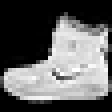

In [3]:
convert2image(FashionMNIST, train_set.features)[:,:,1]

Using package CUDA and CuDNN for GPU

In [4]:
use_cuda = true
if use_cuda && CUDA.functional()
    device = gpu
    @info "Training on GPU"
else
    device = cpu
    @info "Training on CPU"
end

┌ Info: Training on GPU
└ @ Main /home/cuongvosgh/Deep_learning/Final_report/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sdnNjb2RlLXJlbW90ZQ==.jl:4


Initialize for epochs and batch_size

In [5]:
epochs = 150;
batch_size = 16;

Create mini batch

In [6]:
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X)[1], size(X)[2], 1, length(idxs))
    for i in 1:length(idxs)
        X_batch[:, :, 1, i] = Float32.(X[:, :, idxs[i]])
    end
    Y_batch = Flux.onehotbatch(Y[idxs], 0:9)
    return (X_batch, Y_batch)
end

make_minibatch (generic function with 1 method)

In [7]:
mb_idxs = partition(1:size(train_set.features)[3], batch_size)
train_set = [make_minibatch(train_set.features, train_set.targets, i) for i in mb_idxs] |> device

3750-element Vector{Tuple{CuArray{Float32, 4, CUDA.DeviceMemory}, OneHotArrays.OneHotMatrix{UInt32, CuArray{UInt32, 1, CUDA.DeviceMemory}}}}:
 ([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 1 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 1 0 … 0 1])
 ([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; …

Prepare for test dataset

In [8]:
test_set = FashionMNIST(:test)
test_set = make_minibatch(test_set.features, test_set.targets, 1:size(test_set.features)[3]) |> device

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 1 0; … ; 0 0 … 0 0; 1 0 … 0 0])

<b> OLD MODEL </b>

In [ ]:
model = Chain(
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 128),
    Dense(128, 10),
    softmax,
) |> device

<b> IMPROVED MODEL </b>

In [9]:
model = Chain(
    Conv((3, 3), 1=>32, pad=(1, 1), relu),
    BatchNorm(32),
    Conv((3, 3), 32=>32, pad=(1, 1), relu),
    BatchNorm(32),
    Conv((5, 5), 32=>32, stride=(2, 2), pad=(2, 2), relu),
    BatchNorm(32),
    Dropout(0.4),

    Conv((3, 3), 32=>64, pad=(1, 1), relu),
    BatchNorm(64),
    Conv((3, 3), 64=>64, pad=(1, 1), relu),
    BatchNorm(64),
    Conv((5, 5), 64=>64, stride=(2, 2), pad=(2, 2), relu),
    BatchNorm(64),
    Dropout(0.4),

    Conv((3, 3), 64=>128, pad=(1, 1), relu),
    BatchNorm(128),
    Conv((3, 3), 128=>128, pad=(1, 1), relu),
    BatchNorm(128),
    Conv((5, 5), 128=>128, stride=(2, 2), pad=(2, 2), relu),
    BatchNorm(128),
    Dropout(0.4),
    
    x -> reshape(x, :, size(x, 4)),
    Dense(2048, 512, relu),
    BatchNorm(512),
    Dropout(0.4),
    Dense(512, 128, relu),
    BatchNorm(128),
    Dropout(0.4),
    Dense(128, 10),
    softmax,
) |> device

Chain(
  Conv((3, 3), 1 => 32, relu, pad=1),   # 320 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  Conv((3, 3), 32 => 32, relu, pad=1),  # 9_248 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  Conv((5, 5), 32 => 32, relu, pad=2, stride=2),  # 25_632 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  Dropout(0.4),
  Conv((3, 3), 32 => 64, relu, pad=1),  # 18_496 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  Conv((3, 3), 64 => 64, relu, pad=1),  # 36_928 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  Conv((5, 5), 64 => 64, relu, pad=2, stride=2),  # 102_464 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  Dropout(0.4),
  Conv((3, 3), 64 => 128, relu, pad=1),  # 73_856 parameters
  BatchNorm(128),                       # 256 parameters, plus 256
  Conv((3, 3), 128 => 128, relu, pad=1),  # 147_584 paramete

In [10]:
model(train_set[1][1])

10×16 CuArray{Float32, 2, CUDA.DeviceMemory}:
 0.100139   0.100138   0.100056   …  0.100019   0.100095   0.100107
 0.100047   0.0999982  0.100067      0.100055   0.100021   0.100059
 0.0999461  0.0999641  0.0999688     0.0999542  0.0999132  0.099937
 0.100061   0.0999617  0.100001      0.0999652  0.0999856  0.100067
 0.100147   0.100112   0.10007       0.100058   0.100051   0.100188
 0.100002   0.100001   0.100014   …  0.0999995  0.0999585  0.0999647
 0.0998687  0.0999438  0.0999141     0.0999353  0.0999654  0.0998312
 0.0999349  0.0999427  0.0999624     0.10005    0.100007   0.100037
 0.0999343  0.100039   0.0999959     0.100024   0.100024   0.0998951
 0.0999203  0.0998994  0.0999519     0.0999385  0.0999789  0.0999141

In [11]:
function loss(model, x, y, device = device)
    x = x |>cpu
    x_aug = x .+ 0.1f0*randn(eltype(x), size(x)) |> device
    y_hat = model(x_aug)
    return Flux.crossentropy(y_hat, y) 
end

loss (generic function with 2 methods)

In [12]:
loss(model, test_set[1],test_set[2])
accuracy(model,x, y) = mean(Flux.onecold(model(x)) .== Flux.onecold(y))
@time accuracy(model,test_set[1],test_set[2])

  7.790224 seconds (9.02 M allocations: 462.183 MiB, 1.54% gc time, 70.45% compilation time)


0.1285

In [13]:
opt = Flux.Adam(0.0001)
opt_state = Flux.setup(opt, model);
lr_schedule = ParameterSchedulers.Stateful(Exp(start = opt.eta/10, decay = 0.1))

ParameterSchedulers.Stateful{Exp{Float64}, Int64, ParameterSchedulers.var"#15#17"}(Exp{Float64}(1.0e-5, 0.1), 1, ParameterSchedulers.var"#15#17"())

In [14]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:epochs
    global best_acc, last_improvement
    Flux.train!(loss, model, train_set, opt_state)
    acc = accuracy(model,test_set[1],test_set[2])
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch, acc))
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to fashionMNIST_conv.bson")
        ps = cpu(Flux.state(model))
        BSON.@save "fashionMNIST_conv.bson" ps
        jldsave("fashionMNIST_conv.jld2"; ps)
        best_acc = acc
        last_improvement = epoch
    end
    if acc >= 0.95
        @info(" -> Early-exiting: We reached our target accuracy of 95%")
        break
    end
    if epoch - last_improvement >= 5 
        η = ParameterSchedulers.next!(lr_schedule) 
        if η ≥ 1e-10
            Optimisers.adjust(opt_state, eta = η)
            @warn(" -> Haven't improved in a while, dropping learning rate to $(η)!")
            last_improvement = epoch
        end
    end
    if epoch - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: Beginning training loop...
└ @ Main /home/cuongvosgh/Deep_learning/Final_report/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X34sdnNjb2RlLXJlbW90ZQ==.jl:1
┌ Info: [1]: Test accuracy: 0.7726
└ @ Main /home/cuongvosgh/Deep_learning/Final_report/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X34sdnNjb2RlLXJlbW90ZQ==.jl:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main /home/cuongvosgh/Deep_learning/Final_report/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X34sdnNjb2RlLXJlbW90ZQ==.jl:10
┌ Info: [2]: Test accuracy: 0.8381
└ @ Main /home/cuongvosgh/Deep_learning/Final_report/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X34sdnNjb2RlLXJlbW90ZQ==.jl:8
┌ Info:  -> New best accuracy! Saving model out to fashionMNIST_conv.bson
└ @ Main /home/cuongvosgh/Deep_learning/Final_report/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X34sdnNjb2RlLXJlbW90ZQ==.jl:10
┌ Info: [3]: Test accuracy: 0.8645
└ @ Main /home/cuongvosgh/Deep_learning/Final

By implementing batch normalization, dropout, and reducing the learning rate, I was able to improve the accuracy of my Convolutional Neural Network (CNN) from 90% to 92.32%. Batch normalization stabilized and accelerated the training process, while dropout reduced overfitting by encouraging the network to generalize better. Adjusting the learning rate helped the optimizer converge more effectively, allowing the model to learn finer details in the data. These enhancements collectively contributed to the notable accuracy improvement.

In [15]:
isfile("fashionMNIST_conv.bson") ||
download("https://github.com/bartoszpankratz/221660-0553-Aproksymacja/blob/master/5.%20Sieci%20konwolucyjne/fashionMNIST_conv.bson?raw=true")

model = Chain(
    Conv((3, 3), 1=>32, pad=(1, 1), relu),
    BatchNorm(32),
    Conv((3, 3), 32=>32, pad=(1, 1), relu),
    BatchNorm(32),
    Conv((5, 5), 32=>32, stride=(2, 2), pad=(2, 2), relu),
    BatchNorm(32),
    Dropout(0.4),

    Conv((3, 3), 32=>64, pad=(1, 1), relu),
    BatchNorm(64),
    Conv((3, 3), 64=>64, pad=(1, 1), relu),
    BatchNorm(64),
    Conv((5, 5), 64=>64, stride=(2, 2), pad=(2, 2), relu),
    BatchNorm(64),
    Dropout(0.4),

    Conv((3, 3), 64=>128, pad=(1, 1), relu),
    BatchNorm(128),
    Conv((3, 3), 128=>128, pad=(1, 1), relu),
    BatchNorm(128),
    Conv((5, 5), 128=>128, stride=(2, 2), pad=(2, 2), relu),
    BatchNorm(128),
    Dropout(0.4),
    
    x -> reshape(x, :, size(x, 4)),
    Dense(2048, 512, relu),
    BatchNorm(512),
    Dropout(0.4),
    Dense(512, 128, relu),
    BatchNorm(128),
    Dropout(0.4),
    Dense(128, 10),
    softmax,
) |> device

BSON.@load "fashionMNIST_conv.bson" ps

Flux.loadmodel!(model, device(ps))

Chain(
  Conv((3, 3), 1 => 32, relu, pad=1),   # 320 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  Conv((3, 3), 32 => 32, relu, pad=1),  # 9_248 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  Conv((5, 5), 32 => 32, relu, pad=2, stride=2),  # 25_632 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  Dropout(0.4),
  Conv((3, 3), 32 => 64, relu, pad=1),  # 18_496 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  Conv((3, 3), 64 => 64, relu, pad=1),  # 36_928 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  Conv((5, 5), 64 => 64, relu, pad=2, stride=2),  # 102_464 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  Dropout(0.4),
  Conv((3, 3), 64 => 128, relu, pad=1),  # 73_856 parameters
  BatchNorm(128),                       # 256 parameters, plus 256
  Conv((3, 3), 128 => 128, relu, pad=1),  # 147_584 paramete

In [16]:
accuracy(model,test_set[1],test_set[2])

0.9248

In [17]:
isfile("fashionMNIST_conv.jld2") ||
download("https://github.com/bartoszpankratz/221660-0553-Aproksymacja/blob/master/5.%20Sieci%20konwolucyjne/fashionMNIST_conv.jld2?raw=true")

model = Chain(
    Conv((3, 3), 1=>32, pad=(1, 1), relu),
    BatchNorm(32),
    Conv((3, 3), 32=>32, pad=(1, 1), relu),
    BatchNorm(32),
    Conv((5, 5), 32=>32, stride=(2, 2), pad=(2, 2), relu),
    BatchNorm(32),
    Dropout(0.4),

    Conv((3, 3), 32=>64, pad=(1, 1), relu),
    BatchNorm(64),
    Conv((3, 3), 64=>64, pad=(1, 1), relu),
    BatchNorm(64),
    Conv((5, 5), 64=>64, stride=(2, 2), pad=(2, 2), relu),
    BatchNorm(64),
    Dropout(0.4),

    Conv((3, 3), 64=>128, pad=(1, 1), relu),
    BatchNorm(128),
    Conv((3, 3), 128=>128, pad=(1, 1), relu),
    BatchNorm(128),
    Conv((5, 5), 128=>128, stride=(2, 2), pad=(2, 2), relu),
    BatchNorm(128),
    Dropout(0.4),
    
    x -> reshape(x, :, size(x, 4)),
    Dense(2048, 512, relu),
    BatchNorm(512),
    Dropout(0.4),
    Dense(512, 128, relu),
    BatchNorm(128),
    Dropout(0.4),
    Dense(128, 10),
    softmax,
) |> device


ps = JLD2.load("fashionMNIST_conv.jld2", "ps")

Flux.loadmodel!(model, device(ps))

Chain(
  Conv((3, 3), 1 => 32, relu, pad=1),   # 320 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  Conv((3, 3), 32 => 32, relu, pad=1),  # 9_248 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  Conv((5, 5), 32 => 32, relu, pad=2, stride=2),  # 25_632 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  Dropout(0.4),
  Conv((3, 3), 32 => 64, relu, pad=1),  # 18_496 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  Conv((3, 3), 64 => 64, relu, pad=1),  # 36_928 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  Conv((5, 5), 64 => 64, relu, pad=2, stride=2),  # 102_464 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  Dropout(0.4),
  Conv((3, 3), 64 => 128, relu, pad=1),  # 73_856 parameters
  BatchNorm(128),                       # 256 parameters, plus 256
  Conv((3, 3), 128 => 128, relu, pad=1),  # 147_584 paramete

In [18]:
accuracy(model,test_set[1],test_set[2])

0.9248